## Grandient Boosting Modeling for Math ##

The models are:
- CatBoost
- XGBoost
- LightGBM
- HistGradientBoosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# import warnings 
# warnings.filterwarnings('ignore')

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

Loading the data cleaned from [Data_Integration.ipynb](../processing/Data_Integration.ipynb)

In [3]:
df = pd.read_csv('../processing/DATA_Texas_District_v2.csv', sep=',', header=0)
print(df.shape)

(955, 90)


Loading the Feature Selection result report from [Feature_Selection_Math.ipynb](../processing/Feature_Selection_Math.ipynb)

In [4]:
report = pd.read_csv('../processing/Feature_Selection_Math_Report.csv', sep=',', header=0)
report = report.sort_values(by=['MCC', 'F1'], ascending=False, ignore_index=True)
print(report.shape)

(85, 11)


**Get dummies for categorical feature `Locale`**

In [5]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(955, 101)


**Split data**

In [6]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']
cols_drop = ['% Tested Reading G3 Diff',
            '% Tested Reading G4 Diff',
            '% Tested Reading G5 Diff',
            '% Tested Reading G6 Diff',
            '% Tested Reading G7 Diff',
            '% Tested Reading G8 Diff',
            'District #', 'County #']

df['Label'] = df['Label_Math'].apply(lambda x: 0 if x == -1
                                             else 1 if x == 0
                                             else 2)

y = df['Label'].values
X = df.drop(columns=labels + cols_drop + ['Label']).copy()
columns = df.drop(columns=labels + cols_drop + ['Label']).columns.to_list()
categorical_cols = [c for c in columns if 'Locale' in c]
categorical_cols_idx = [columns.index(c) for c in columns if 'Locale' in c]
numerical_cols = [c for c in columns if c not in categorical_cols]

random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)
print(X.shape)

(955, 90)


In [7]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,0,166,41
1,1,412,103
2,2,186,47


**Normalization**

In [8]:
# scaler = StandardScaler()

# scaler.fit(X_train[numerical_cols])
# X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
# X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Experiment with the Feature Sets selected from [Feature_Selection_Math.ipynb](../processing/Feature_Selection_Math.ipynb) ###

In [9]:
print('Feature Set 1 (Original Set)')
print('\tn features:', len(columns))

feature_set = report[(report['model'] == 'Ridge') & (report['type'] == 'by methods')].sort_values(by=['n Selected'], ignore_index=True)
n = feature_set.shape[0]

for i in range(n):
    print('Feature Set', str(i+2))
    print('\tn features: {:0.0f}'.format(feature_set.loc[i, 'n Selected']))
    if feature_set.loc[i, 'type'] == 'by counts': 
        print('\tSelected by {:0.0f} methods'.format(feature_set.loc[i, 'Counts']))

Feature Set 1 (Original Set)
	n features: 90
Feature Set 2
	n features: 6
Feature Set 3
	n features: 21
Feature Set 4
	n features: 28
Feature Set 5
	n features: 36
Feature Set 6
	n features: 45
Feature Set 7
	n features: 45
Feature Set 8
	n features: 45
Feature Set 9
	n features: 55
Feature Set 10
	n features: 70


**n iteration for models**

In [10]:
def get_n_iter (param_grid):
    n_iter_ratio = 0.2
    n_iter = 1
    for v in param_grid.values(): n_iter*=len(v)
    n_iter *= n_iter_ratio

    return int(n_iter)

### Modeling ###

In [11]:
rounds = 20

In [12]:
def model_report(estimator, param_grid, name, fit_params):
    result = pd.DataFrame()
    avg = 'weighted'
    cv=5
    
    n_iter=get_n_iter(param_grid)
    print('{} n_iter: {:0.0f}'.format(name, n_iter))     
    if name == 'CatBoost': n_iter=100
       
    for i in range(n+1):
        if i == n: 
            features = columns
            method = 'No Reduction'
        else: 
            features = list(feature_set.loc[i, 'features'].strip("[]''").split("', '"))
            method = feature_set.loc[i, 'Method']
            
        X_train2 = X_train.loc[:, features].copy()
        X_test2 = X_test.loc[:, features].copy()                        
        
        categorical_cols_inx=[features.index(f) for f in features if f in categorical_cols]
        if len(categorical_cols_inx) > 0:
            if (name == 'LightGBM'): fit_params['categorical_feature']=categorical_cols_inx
            if (name == 'CatBoost'): fit_params['cat_features']=categorical_cols_inx
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': categorical_cols_inx})
            if (name == 'XGBoost'):
                X_train2=X_train2.astype({features[c]: 'category' for c in categorical_cols_inx})
                X_test2=X_test2.astype({features[c]: 'category' for c in categorical_cols_inx})
        else: 
            if (name == 'LightGBM'): fit_params['categorical_feature']=None
            if (name == 'CatBoost'): fit_params['cat_features']=None
            if (name == 'HistGB'): estimator.set_params(**{'categorical_features': None})
              
        grid = RandomizedSearchCV(estimator, param_distributions=param_grid, cv=cv, n_jobs=-1, 
                              random_state=random_state, n_iter=n_iter)

        start_cpu = time.process_time()
        start_wall = time.time()
        
        if name == 'HistGB': 
            grid.fit(X_train2, y_train)
        elif name == 'LightGBM':
            fit_params['eval_set'] =  [(X_test2.values, y_test)]
            grid.fit(X_train2.values, y_train, **fit_params)
        else:
            fit_params['eval_set'] =  [(X_test2, y_test)]
            grid.fit(X_train2, y_train, **fit_params)            
       
        if name == 'XGBoost': grid.best_estimator_.save_model("categorical-model.json")
            
        cpu_time = time.process_time() - start_cpu
        wall_time = time.time() - start_wall
        y_pred = grid.best_estimator_.predict(X_test2)
        
        temp = {'Model': name,
                'n Selected': len(features),
                'Method': method,
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average=avg),
                'Recall': recall_score(y_test, y_pred, average=avg),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'F1': f1_score(y_test, y_pred, average=avg),
#                 'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'Prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'Features': features,
                'estimator': grid.best_estimator_,
                'classification_report': classification_report(y_test, y_pred),
                'Train Time CPU': cpu_time,
                'Train Time Wall': wall_time,
                'n_iter': n_iter}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

In [13]:
results = pd.DataFrame()

**CatBoost**

In [14]:
%%time
from catboost import CatBoostClassifier

params = {'iterations': [50, 100, 200],
'depth': [3, 6, 9],
'min_data_in_leaf': [1, 5, 10],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
'random_strength': [0, 5, 10, 15]}

fit_params = {'early_stopping_rounds': rounds}

estimator = CatBoostClassifier(random_seed=random_state, verbose=False, 
                               loss_function='MultiClass', eval_metric="MultiClass", one_hot_max_size=4, border_count=254)
                               
result_report=model_report(estimator, params, 'CatBoost', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

CatBoost n_iter: 432
CPU times: total: 43.1 s
Wall time: 2h 3min 47s


**XGBoost**

In [15]:
%%time
import xgboost

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, 0],
'min_child_weight': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'alpha': [0,  0.1, 10],
'lambda': [0,  0.1, 10],
'gamma': [0,  0.1, 10]}

# fit_params = {'early_stopping_rounds': rounds,
#               'eval_metric': 'mlogloss'}

estimator = xgboost.XGBClassifier(seed=random_state, objective='multi:softproba', eval_metric='mlogloss', use_label_encoder=False, verbosity=0,
                                  num_class=3, tree_method="hist", early_stopping_rounds=rounds, enable_categorical=True, max_cat_to_onehot=4)

result_report=model_report(estimator, params, 'XGBoost', {})
results=pd.concat([results, result_report], ignore_index=True)

XGBoost n_iter: 777
[0]	validation_0-mlogloss:1.06811
[1]	validation_0-mlogloss:1.04061
[2]	validation_0-mlogloss:1.01773
[3]	validation_0-mlogloss:0.99676
[4]	validation_0-mlogloss:0.97835
[5]	validation_0-mlogloss:0.96191
[6]	validation_0-mlogloss:0.94757
[7]	validation_0-mlogloss:0.93474
[8]	validation_0-mlogloss:0.92348
[9]	validation_0-mlogloss:0.91339
[10]	validation_0-mlogloss:0.90450
[11]	validation_0-mlogloss:0.89573
[12]	validation_0-mlogloss:0.88823
[13]	validation_0-mlogloss:0.88171
[14]	validation_0-mlogloss:0.87493
[15]	validation_0-mlogloss:0.86869
[16]	validation_0-mlogloss:0.86358
[17]	validation_0-mlogloss:0.85805
[18]	validation_0-mlogloss:0.85393
[19]	validation_0-mlogloss:0.84890
[20]	validation_0-mlogloss:0.84570
[21]	validation_0-mlogloss:0.84184
[22]	validation_0-mlogloss:0.83839
[23]	validation_0-mlogloss:0.83503
[24]	validation_0-mlogloss:0.83190
[25]	validation_0-mlogloss:0.82917
[26]	validation_0-mlogloss:0.82627
[27]	validation_0-mlogloss:0.82447
[28]	valid

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\sit

[0]	validation_0-mlogloss:1.09497
[1]	validation_0-mlogloss:1.09139
[2]	validation_0-mlogloss:1.08786
[3]	validation_0-mlogloss:1.08439
[4]	validation_0-mlogloss:1.08098
[5]	validation_0-mlogloss:1.07762
[6]	validation_0-mlogloss:1.07431
[7]	validation_0-mlogloss:1.07105
[8]	validation_0-mlogloss:1.06759
[9]	validation_0-mlogloss:1.06431
[10]	validation_0-mlogloss:1.06133
[11]	validation_0-mlogloss:1.05819
[12]	validation_0-mlogloss:1.05515
[13]	validation_0-mlogloss:1.05222
[14]	validation_0-mlogloss:1.04923
[15]	validation_0-mlogloss:1.04639
[16]	validation_0-mlogloss:1.04346
[17]	validation_0-mlogloss:1.04071
[18]	validation_0-mlogloss:1.03799
[19]	validation_0-mlogloss:1.03521
[20]	validation_0-mlogloss:1.03256
[21]	validation_0-mlogloss:1.02986
[22]	validation_0-mlogloss:1.02719
[23]	validation_0-mlogloss:1.02462
[24]	validation_0-mlogloss:1.02199
[25]	validation_0-mlogloss:1.01961
[26]	validation_0-mlogloss:1.01716
[27]	validation_0-mlogloss:1.01471
[28]	validation_0-mlogloss:1.0

[32]	validation_0-mlogloss:0.83033
[33]	validation_0-mlogloss:0.82794
[34]	validation_0-mlogloss:0.82714
[35]	validation_0-mlogloss:0.82660
[36]	validation_0-mlogloss:0.82588
[37]	validation_0-mlogloss:0.82497
[38]	validation_0-mlogloss:0.82349
[39]	validation_0-mlogloss:0.82261
[40]	validation_0-mlogloss:0.82118
[41]	validation_0-mlogloss:0.82063
[42]	validation_0-mlogloss:0.81986
[43]	validation_0-mlogloss:0.81860
[44]	validation_0-mlogloss:0.81756
[45]	validation_0-mlogloss:0.81736
[46]	validation_0-mlogloss:0.81701
[47]	validation_0-mlogloss:0.81625
[48]	validation_0-mlogloss:0.81505
[49]	validation_0-mlogloss:0.81378
[50]	validation_0-mlogloss:0.81364
[51]	validation_0-mlogloss:0.81347
[52]	validation_0-mlogloss:0.81213
[53]	validation_0-mlogloss:0.81252
[54]	validation_0-mlogloss:0.81186
[55]	validation_0-mlogloss:0.81207
[56]	validation_0-mlogloss:0.81207
[57]	validation_0-mlogloss:0.81090
[58]	validation_0-mlogloss:0.81042
[59]	validation_0-mlogloss:0.81000
[60]	validation_0-ml

[178]	validation_0-mlogloss:0.84833
[179]	validation_0-mlogloss:0.84810
[180]	validation_0-mlogloss:0.84776
[181]	validation_0-mlogloss:0.84739
[182]	validation_0-mlogloss:0.84718
[183]	validation_0-mlogloss:0.84682
[184]	validation_0-mlogloss:0.84649
[185]	validation_0-mlogloss:0.84617
[186]	validation_0-mlogloss:0.84581
[187]	validation_0-mlogloss:0.84562
[188]	validation_0-mlogloss:0.84529
[189]	validation_0-mlogloss:0.84498
[190]	validation_0-mlogloss:0.84463
[191]	validation_0-mlogloss:0.84444
[192]	validation_0-mlogloss:0.84414
[193]	validation_0-mlogloss:0.84383
[194]	validation_0-mlogloss:0.84349
[195]	validation_0-mlogloss:0.84315
[196]	validation_0-mlogloss:0.84298
[197]	validation_0-mlogloss:0.84268
[198]	validation_0-mlogloss:0.84235
[199]	validation_0-mlogloss:0.84206
[0]	validation_0-mlogloss:1.09492
[1]	validation_0-mlogloss:1.09124
[2]	validation_0-mlogloss:1.08756
[3]	validation_0-mlogloss:1.08414
[4]	validation_0-mlogloss:1.08069
[5]	validation_0-mlogloss:1.07735
[6]	

[10]	validation_0-mlogloss:1.06605
[11]	validation_0-mlogloss:1.06324
[12]	validation_0-mlogloss:1.06046
[13]	validation_0-mlogloss:1.05784
[14]	validation_0-mlogloss:1.05514
[15]	validation_0-mlogloss:1.05258
[16]	validation_0-mlogloss:1.04995
[17]	validation_0-mlogloss:1.04736
[18]	validation_0-mlogloss:1.04491
[19]	validation_0-mlogloss:1.04238
[20]	validation_0-mlogloss:1.04000
[21]	validation_0-mlogloss:1.03753
[22]	validation_0-mlogloss:1.03511
[23]	validation_0-mlogloss:1.03281
[24]	validation_0-mlogloss:1.03045
[25]	validation_0-mlogloss:1.02822
[26]	validation_0-mlogloss:1.02580
[27]	validation_0-mlogloss:1.02352
[28]	validation_0-mlogloss:1.02116
[29]	validation_0-mlogloss:1.01883
[30]	validation_0-mlogloss:1.01664
[31]	validation_0-mlogloss:1.01436
[32]	validation_0-mlogloss:1.01223
[33]	validation_0-mlogloss:1.01001
[34]	validation_0-mlogloss:1.00781
[35]	validation_0-mlogloss:1.00576
[36]	validation_0-mlogloss:1.00362
[37]	validation_0-mlogloss:1.00150
[38]	validation_0-ml

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\sit

[0]	validation_0-mlogloss:1.09497
[1]	validation_0-mlogloss:1.09139
[2]	validation_0-mlogloss:1.08786
[3]	validation_0-mlogloss:1.08439
[4]	validation_0-mlogloss:1.08098
[5]	validation_0-mlogloss:1.07762
[6]	validation_0-mlogloss:1.07431
[7]	validation_0-mlogloss:1.07105
[8]	validation_0-mlogloss:1.06759
[9]	validation_0-mlogloss:1.06431
[10]	validation_0-mlogloss:1.06133
[11]	validation_0-mlogloss:1.05819
[12]	validation_0-mlogloss:1.05515
[13]	validation_0-mlogloss:1.05222
[14]	validation_0-mlogloss:1.04923
[15]	validation_0-mlogloss:1.04639
[16]	validation_0-mlogloss:1.04346
[17]	validation_0-mlogloss:1.04071
[18]	validation_0-mlogloss:1.03799
[19]	validation_0-mlogloss:1.03521
[20]	validation_0-mlogloss:1.03256
[21]	validation_0-mlogloss:1.02986
[22]	validation_0-mlogloss:1.02719
[23]	validation_0-mlogloss:1.02462
[24]	validation_0-mlogloss:1.02199
[25]	validation_0-mlogloss:1.01961
[26]	validation_0-mlogloss:1.01716
[27]	validation_0-mlogloss:1.01471
[28]	validation_0-mlogloss:1.0

**LightGBM**

In [16]:
%%time
import lightgbm as lgb

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, -1],
'min_sum_hessian_in_leaf': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'reg_alpha': [0,  0.1, 10],
'reg_lambda': [0,  0.1, 10],
'min_split_gain': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds}

estimator = lgb.LGBMClassifier(random_state=random_state, objective="multiclass", metric="multi_logloss", verbosity=-1, silent=True, force_col_wise=True,
                               num_class=3, is_unbalance=True, max_cat_threshold=32)
                               
result_report=model_report(estimator, params, 'LightGBM', fit_params)
results=pd.concat([results, result_report], ignore_index=True)

LightGBM n_iter: 777
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 0.947473
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.909329
[3]	valid_0's multi_logloss: 0.886051
[4]	valid_0's multi_logloss: 0.868725
[5]	valid_0's multi_logloss: 0.850474
[6]	valid_0's multi_logloss: 0.838274
[7]	valid_0's multi_logloss: 0.830615
[8]	valid_0's multi_logloss: 0.821277
[9]	valid_0's multi_logloss: 0.814274
[10]	valid_0's multi_logloss: 0.809357
[11]	valid_0's multi_logloss: 0.806256
[12]	valid_0's multi_logloss: 0.801137
[13]	valid_0's multi_logloss: 0.797412
[14]	valid_0's multi_logloss: 0.794518
[15]	valid_0's multi_logloss: 0.792595
[16]	valid_0's multi_logloss: 0.790198
[17]	valid_0's multi_logloss: 0.789991
[18]	valid_0's multi_logloss: 0.789138
[19]	valid_0's multi_logloss: 0.787912
[20]	valid_0's multi_logloss: 0.788034
[21

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [12]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 0.937892
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.897166
[3]	valid_0's multi_logloss: 0.879559
[4]	valid_0's multi_logloss: 0.869642
[5]	valid_0's multi_logloss: 0.861713
[6]	valid_0's multi_logloss: 0.857534
[7]	valid_0's multi_logloss: 0.848823
[8]	valid_0's multi_logloss: 0.846038
[9]	valid_0's multi_logloss: 0.845559
[10]	valid_0's multi_logloss: 0.842455
[11]	valid_0's multi_logloss: 0.843496
[12]	valid_0's multi_logloss: 0.848599
[13]	valid_0's multi_logloss: 0.850428
[14]	valid_0's multi_logloss: 0.85042
[15]	valid_0's multi_logloss: 0.856778
[16]	valid_0's multi_logloss: 0.857667
[17]	valid_0's multi_logloss: 0.860576
[18]	valid_0's multi_logloss: 0.860085
[19]	valid_0's multi_logloss: 0.861145
[20]	valid_0's multi_logloss: 0.863291
[21]	valid_0's multi_logl

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [7, 11, 19, 20, 21]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 1.00583
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 1.00338
[3]	valid_0's multi_logloss: 1.00098
[4]	valid_0's multi_logloss: 0.9986
[5]	valid_0's multi_logloss: 0.996312
[6]	valid_0's multi_logloss: 0.994077
[7]	valid_0's multi_logloss: 0.991862
[8]	valid_0's multi_logloss: 0.989444
[9]	valid_0's multi_logloss: 0.987068
[10]	valid_0's multi_logloss: 0.984695
[11]	valid_0's multi_logloss: 0.9824
[12]	valid_0's multi_logloss: 0.980144
[13]	valid_0's multi_logloss: 0.977993
[14]	valid_0's multi_logloss: 0.975809
[15]	valid_0's multi_logloss: 0.973766
[16]	valid_0's multi_logloss: 0.971613
[17]	valid_0's multi_logloss: 0.969637
[18]	valid_0's multi_logloss: 0.967585
[19]	valid_0's multi_logloss: 0.965532
[20]	valid_0's multi_logloss: 0.963649
[21]	valid_0's multi_logloss: 0

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\sit

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[1]	valid_0's multi_logloss: 0.984317
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.961848
[3]	valid_0's multi_logloss: 0.943424
[4]	valid_0's multi_logloss: 0.92761
[5]	valid_0's multi_logloss: 0.915384
[6]	valid_0's multi_logloss: 0.902838
[7]	valid_0's multi_logloss: 0.892
[8]	valid_0's multi_logloss: 0.883856
[9]	valid_0's multi_logloss: 0.875321
[10]	valid_0's multi_logloss: 0.866488
[11]	valid_0's multi_logloss: 0.861269
[12]	valid_0's multi_logloss: 0.857185
[13]	valid_0's multi_logloss: 0.851739
[14]	valid_0's multi_logloss: 0.846723
[15]	valid_0's multi_logloss: 0.845189
[16]	valid_0's multi_logloss: 0.840599
[17]	valid_0's multi_logloss: 0.838902
[18]	valid_0's multi_logloss: 0.835838
[19]	valid_0's multi_logloss: 0.83501
[20]	valid_0's multi_logloss: 0.832342
[21]	valid_0's multi_logloss: 0.82980

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\sit

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 0.92201
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.875671
[3]	valid_0's multi_logloss: 0.842539
[4]	valid_0's multi_logloss: 0.824992
[5]	valid_0's multi_logloss: 0.809883
[6]	valid_0's multi_logloss: 0.800034
[7]	valid_0's multi_logloss: 0.795974
[8]	valid_0's multi_logloss: 0.788675
[9]	valid_0's multi_logloss: 0.785083
[10]	valid_0's multi_logloss: 0.786277
[11]	valid_0's multi_logloss: 0.788677
[12]	valid_0's multi_logloss: 0.785299
[13]	valid_0's multi_logloss: 0.780936
[14]	valid_0's multi_logloss: 0.775046
[15]	valid_0's multi_logloss: 0.773948
[16]	valid_0's multi_logloss: 0.778904
[17]	valid_0's multi_logloss: 0.784259
[18]	valid_0's multi_logloss: 0.787915
[19]	valid_0's multi_logloss: 0.787413
[20]	valid_0's multi_logloss: 0.788909
[21]	valid_0's multi_logl

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 28, 36, 37, 38, 39, 49, 50, 51, 54]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's multi_logloss: 0.947698
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.906388
[3]	valid_0's multi_logloss: 0.879384
[4]	valid_0's multi_logloss: 0.857008
[5]	valid_0's multi_logloss: 0.84406
[6]	valid_0's multi_logloss: 0.829238
[7]	valid_0's multi_logloss: 0.820175
[8]	valid_0's multi_logloss: 0.815367
[9]	valid_0's multi_logloss: 0.80747
[10]	valid_0's multi_logloss: 0.80215
[11]	valid_0's multi_logloss: 0.795677
[12]	valid_0's multi_logloss: 0.792945
[13]	valid_0's multi_logloss: 0.790927
[14]	valid_0's multi_logloss: 0.785615
[15]	valid_0's multi_logloss: 0.782705
[16]	valid_0's multi_logloss: 0.781872
[17]	valid_0's multi_logloss: 0.778972
[18]	valid_0's multi_logloss: 0.776848
[19]	valid_0's multi_logloss: 0.775938
[20]	valid_0's multi_logloss: 0.772477
[21]	valid_0's multi_logloss: 0

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [45]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's multi_logloss: 0.922312
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 0.879593
[3]	valid_0's multi_logloss: 0.852445
[4]	valid_0's multi_logloss: 0.837631
[5]	valid_0's multi_logloss: 0.824638
[6]	valid_0's multi_logloss: 0.811711
[7]	valid_0's multi_logloss: 0.807823
[8]	valid_0's multi_logloss: 0.804326
[9]	valid_0's multi_logloss: 0.798386
[10]	valid_0's multi_logloss: 0.793965
[11]	valid_0's multi_logloss: 0.791731
[12]	valid_0's multi_logloss: 0.788316
[13]	valid_0's multi_logloss: 0.783691
[14]	valid_0's multi_logloss: 0.780236
[15]	valid_0's multi_logloss: 0.782503
[16]	valid_0's multi_logloss: 0.783929
[17]	valid_0's multi_logloss: 0.782932
[18]	valid_0's multi_logloss: 0.784388
[19]	valid_0's multi_logloss: 0.784912
[20]	valid_0's multi_logloss: 0.788261
[21]	valid_0's multi_log

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is

**HistGradientBoosting**

In [17]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

params = {'max_iter': [50, 100, 200],
'max_depth': [1, 6, None],
'max_leaf_nodes': [10, 31, 50, 64],
'min_samples_leaf': [10, 20, 30],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_regularization': [0, 0.01, 0.1, 1, 10]}

estimator=HistGradientBoostingClassifier(random_state=random_state, n_iter_no_change=rounds, early_stopping=True)
result_report=model_report(estimator, params, 'HistGB', {})
results=pd.concat([results, result_report], ignore_index=True)

HistGB n_iter: 432


C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC3\anaconda3\envs\ML310\lib\sit

CPU times: total: 1min 46s
Wall time: 11min 43s


## Result ##

In [18]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,MCC,F1,best_params
3,CatBoost,RFE - Random Forest,36,0.675393,0.433526,0.644635,"{'random_strength': 10, 'min_data_in_leaf': 5,..."
11,XGBoost,Variance Threshold,21,0.659686,0.405375,0.616108,"{'n_estimators': 100, 'min_child_weight': 0, '..."
5,CatBoost,Feature Importance - Random Forest,45,0.654450,0.391089,0.627109,"{'random_strength': 0, 'min_data_in_leaf': 10,..."
9,CatBoost,No Reduction,90,0.643979,0.376758,0.586391,"{'random_strength': 0, 'min_data_in_leaf': 5, ..."
28,LightGBM,Permutation Importance - Random Forest,70,0.643979,0.371562,0.600648,"{'reg_lambda': 0, 'reg_alpha': 0, 'n_estimator..."
6,CatBoost,SFS - KNN,45,0.643979,0.370014,0.604092,"{'random_strength': 15, 'min_data_in_leaf': 5,..."
26,LightGBM,SFS - KNN,45,0.628272,0.352806,0.618589,"{'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estima..."
23,LightGBM,RFE - Random Forest,36,0.628272,0.352696,0.534764,"{'reg_lambda': 0, 'reg_alpha': 10, 'n_estimato..."
25,LightGBM,Feature Importance - Random Forest,45,0.628272,0.352696,0.534764,"{'reg_lambda': 0, 'reg_alpha': 10, 'n_estimato..."
29,LightGBM,No Reduction,90,0.628272,0.352696,0.534764,"{'reg_lambda': 0, 'reg_alpha': 10, 'n_estimato..."


In [19]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
LightGBM,5
CatBoost,4
XGBoost,1


In [20]:
results.sort_values(by=['MCC', 'F1'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
21,1
36,2
45,4
70,1
90,2


**Accuracy, MCC and F1 Score**

In [21]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

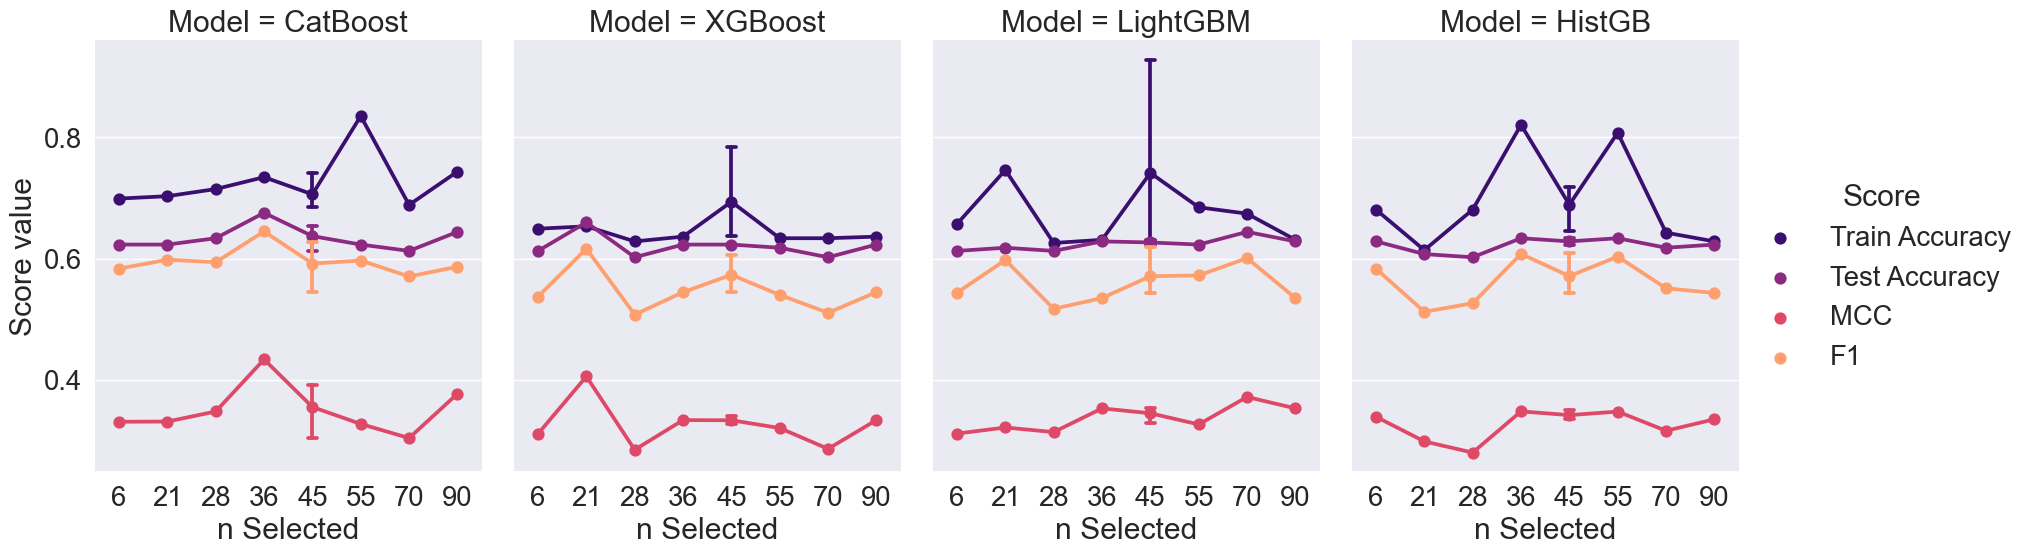

In [22]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [23]:
models = results['Model'].unique().tolist()
temp=results.sort_values(by=['Model', 'MCC', 'F1'], ascending=False)

best_per_model_idx = []
for i in range(len(temp.index)):
    if i % (n+1) == 0: best_per_model_idx.append(temp.index[i])

**Confusion Matrix**

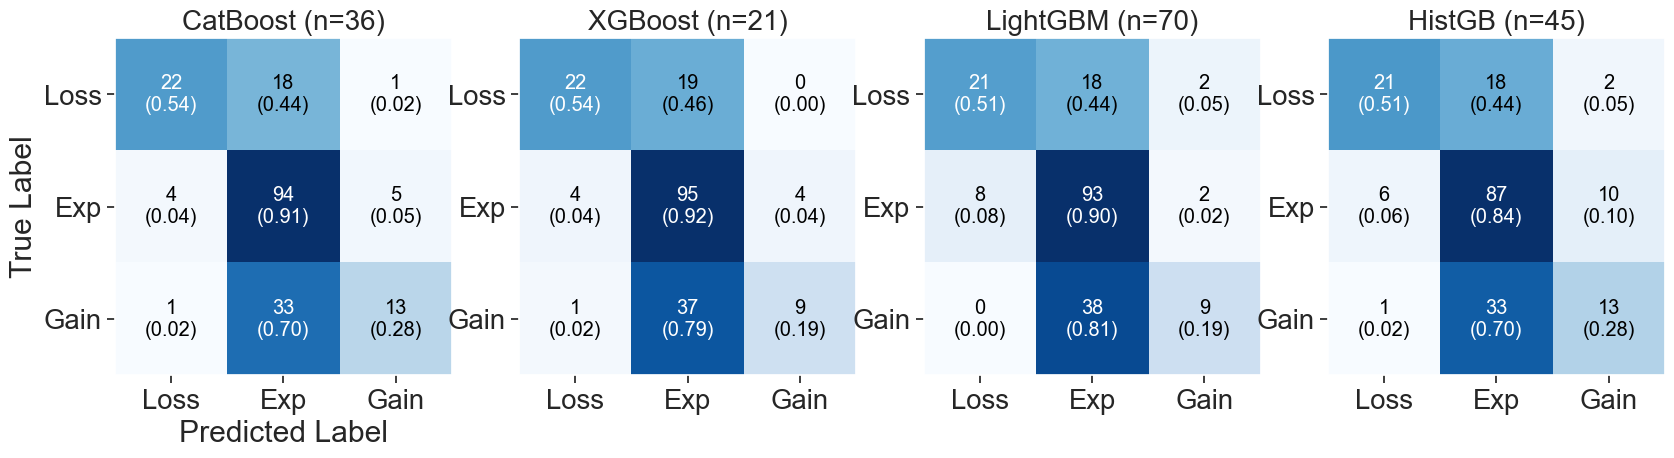

In [24]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as mticker

def ticks(x, position):
    if position == 1: return 'Loss'
    if position == 2: return 'Exp'
    if position == 3: return 'Gain'
    
fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,10))
sns.set(font_scale=1.2)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'],
                          show_absolute=True, show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
    axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(ticks))
    axes[i].yaxis.set_major_formatter(mticker.FuncFormatter(ticks))
plt.show()

**ROC Curve**

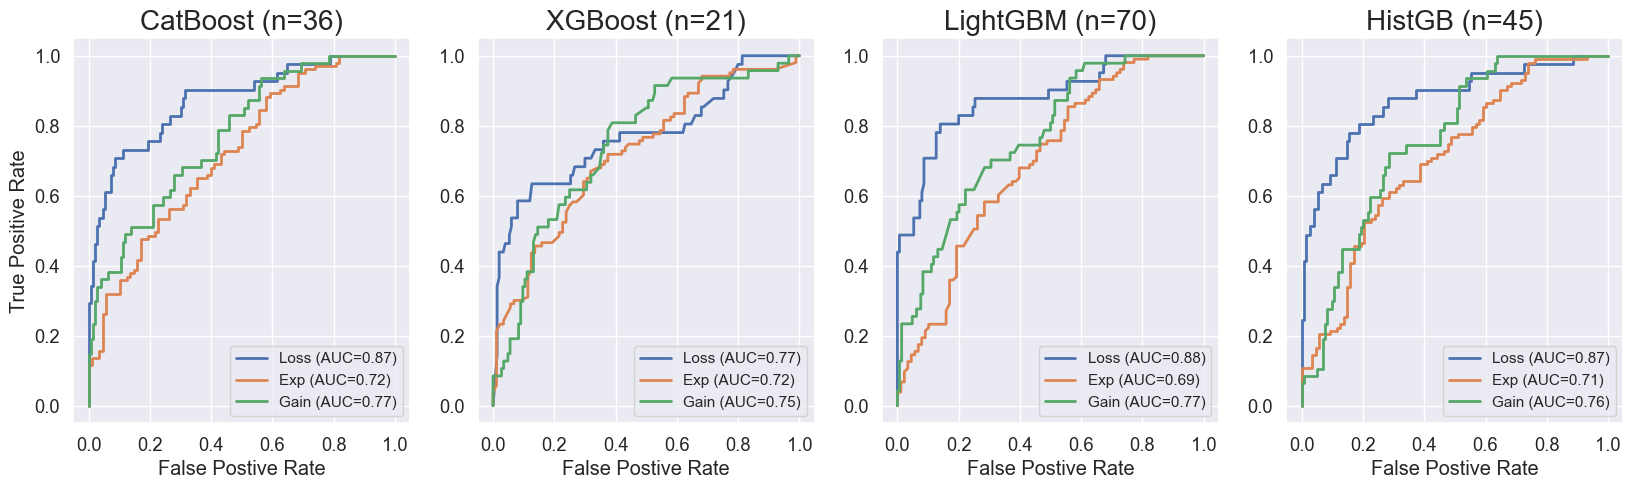

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    fpr, tpr = {}, {}

    for c in classes:
        fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(fpr[c], tpr[c], lw=2, label='{} (AUC={:0.2f})'.format(ticks(c,c+1), auc(fpr[c], tpr[c])))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("False Postive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[i].legend(loc="best")

plt.show()

**Precision-Recall Curve**

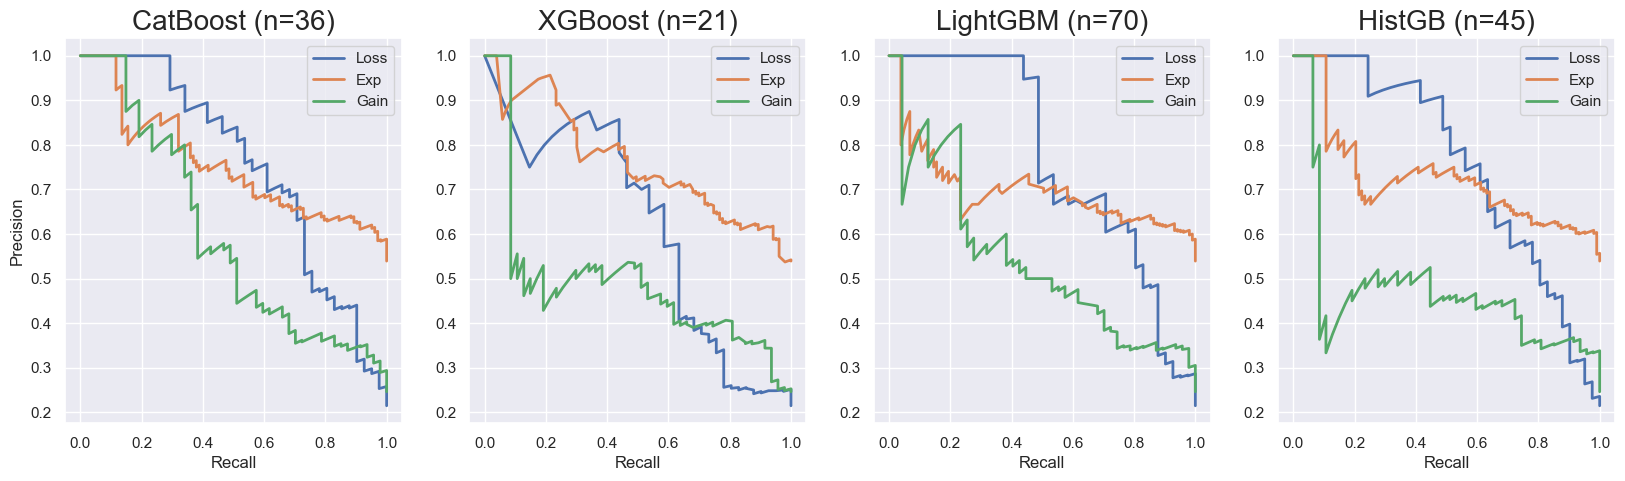

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

classes=[0, 1, 2]
y_test_bin=label_binarize(y_test, classes=classes)

fig, axes=plt.subplots(1,len(best_per_model_idx), figsize=(20,5))
sns.set(font_scale=1)

for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    prec, rec = {}, {}

    for c in classes:
        prec[c], rec[c], _ = precision_recall_curve(y_test_bin[:, c], results.loc[idx, 'predict_proba'][:, c])
        axes[i].plot(rec[c], prec[c], lw=2, label='{}'.format(ticks(c,c+1)))
    
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set_title(title, fontsize=20)
    axes[i].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[i].legend(loc="best")

plt.show()

In [27]:
for idx, i in zip(sorted(best_per_model_idx), range(len(best_per_model_idx))):
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    print(title, '\n', results.loc[idx, 'classification_report'])

CatBoost (n=36) 
               precision    recall  f1-score   support

           0       0.81      0.54      0.65        41
           1       0.65      0.91      0.76       103
           2       0.68      0.28      0.39        47

    accuracy                           0.68       191
   macro avg       0.72      0.58      0.60       191
weighted avg       0.69      0.68      0.64       191

XGBoost (n=21) 
               precision    recall  f1-score   support

           0       0.81      0.54      0.65        41
           1       0.63      0.92      0.75       103
           2       0.69      0.19      0.30        47

    accuracy                           0.66       191
   macro avg       0.71      0.55      0.57       191
weighted avg       0.68      0.66      0.62       191

LightGBM (n=70) 
               precision    recall  f1-score   support

           0       0.72      0.51      0.60        41
           1       0.62      0.90      0.74       103
           2       0.6

In [28]:
results.sort_values(by=['MCC'], ascending=False).to_csv('Modeling_GB_Math.csv')